In [15]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


In [16]:
# Load CSVs (adjust paths if needed)
beef = pd.read_csv("data/beefprice.csv", parse_dates=["observation_date"])
corn = pd.read_csv("data/cornprice.csv", parse_dates=["observation_date"])
soy  = pd.read_csv("data/soybeanprice.csv", parse_dates=["observation_date"])

# Rename columns to simple names (change keys if your CSV uses other column names)
beef = beef.rename(columns={"PBEEFUSDM": "beef"})
corn = corn.rename(columns={"PMAIZMTUSDM": "corn"})
soy  = soy.rename(columns={"PSMEAUSDM": "soybean"})

# Merge on date, set index
df = (
    beef.merge(corn, on="observation_date")
        .merge(soy,  on="observation_date")
        .set_index("observation_date")
        .sort_index()
)

df.head()


,beef,corn,soybean
observation_date,,,
1990-01-01,126.309998,105.900513,191.306128
1990-02-01,111.459991,106.294167,182.267175
1990-03-01,112.670013,109.837318,184.328497
1990-04-01,112.129997,118.498337,191.063619
1990-05-01,112.489990,121.254097,199.970295


## changes in prices

In [17]:
# Take logs of prices
log_prices = np.log(df[["beef", "corn", "soybean"]])

# Log returns: difference of log prices (approx % change)
log_returns = log_prices.diff().dropna()
log_returns.columns = ["beef_ret", "corn_ret", "soy_ret"]

log_returns.head()


,beef_ret,corn_ret,soy_ret
observation_date,,,
1990-02-01,-0.125073,0.003710,-0.048401
1990-03-01,0.010798,0.032790,0.011246
1990-04-01,-0.004804,0.075899,0.035887
1990-05-01,0.003205,0.022989,0.045562
1990-06-01,0.009643,-0.009788,-0.038147


## Check stationarity of returns

In [18]:
def adf_test(series, name=""):
    series = series.dropna()
    result = adfuller(series)
    test_stat, p_value, usedlag, nobs, crit_vals, icbest = result

    print(f"ADF test for {name}")
    print(f"  Test statistic: {test_stat: .4f}")
    print(f"  p-value       : {p_value: .4f}")
    if p_value < 0.05:
        print("  => Stationary at 5% level.\n")
    else:
        print("  => NOT stationary at 5% level.\n")

for col in log_returns.columns:
    adf_test(log_returns[col], name=col)


ADF test for beef_ret
  Test statistic: -6.7093
  p-value       :  0.0000
  => Stationary at 5% level.

ADF test for corn_ret
  Test statistic: -7.8046
  p-value       :  0.0000
  => Stationary at 5% level.

ADF test for soy_ret
  Test statistic: -13.6528
  p-value       :  0.0000
  => Stationary at 5% level.



## Effect of corn & soybean on beef

In [19]:
# Dependent variable: change in beef price
y = log_returns["beef_ret"]

# Independent variables: changes in corn + soybean prices
X = log_returns[["corn_ret", "soy_ret"]]
X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               beef_ret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9821
Date:                Thu, 27 Nov 2025   Prob (F-statistic):              0.375
Time:                        23:36:31   Log-Likelihood:                 752.39
No. Observations:                 425   AIC:                            -1499.
Df Residuals:                     422   BIC:                            -1487.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.973      0.3

## Pairwise correlation matrix

In [20]:
# === Pairwise correlation matrix of log returns ===
corr_matrix = log_returns.corr()
corr_matrix


,beef_ret,corn_ret,soy_ret
beef_ret,1.000000,0.057078,0.060299
corn_ret,0.057078,1.000000,0.490252
soy_ret,0.060299,0.490252,1.000000


## Pairwise OLS regressions (all pairs)

In [21]:
import statsmodels.api as sm
from itertools import permutations
import pandas as pd

results = []

for dep_var, indep_var in permutations(log_returns.columns, 2):
    y = log_returns[dep_var]
    X = sm.add_constant(log_returns[indep_var])  # add intercept
    model = sm.OLS(y, X).fit()
    
    results.append({
        "dependent": dep_var,
        "independent": indep_var,
        "beta": model.params[indep_var],
        "beta_tstat": model.tvalues[indep_var],
        "beta_pvalue": model.pvalues[indep_var],
        "R2": model.rsquared,
        "n_obs": int(model.nobs)
    })

pairwise_results = pd.DataFrame(results)
pairwise_results


,dependent,independent,beta,beta_tstat,beta_pvalue,R2,n_obs
0,beef_ret,corn_ret,0.040613,1.175840,2.403203e-01,0.003258,425
1,beef_ret,soy_ret,0.040111,1.242436,2.147640e-01,0.003636,425
2,corn_ret,beef_ret,0.080218,1.175840,2.403203e-01,0.003258,425
3,corn_ret,soy_ret,0.458323,11.568617,4.416676e-27,0.240347,425
4,soy_ret,beef_ret,0.090649,1.242436,2.147640e-01,0.003636,425
5,soy_ret,corn_ret,0.524404,11.568617,4.416676e-27,0.240347,425


## beef vs corn / soybean

In [22]:
# Beef on corn only
y_bc = log_returns["beef_ret"]
X_bc = sm.add_constant(log_returns["corn_ret"])
model_bc = sm.OLS(y_bc, X_bc).fit()
print("=== beef_ret on corn_ret ===")
print(model_bc.summary())

# Beef on soybean only
y_bs = log_returns["beef_ret"]
X_bs = sm.add_constant(log_returns["soy_ret"])
model_bs = sm.OLS(y_bs, X_bs).fit()
print("\n=== beef_ret on soy_ret ===")
print(model_bs.summary())


=== beef_ret on corn_ret ===
                            OLS Regression Results                            
Dep. Variable:               beef_ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.383
Date:                Thu, 27 Nov 2025   Prob (F-statistic):              0.240
Time:                        23:38:24   Log-Likelihood:                 752.09
No. Observations:                 425   AIC:                            -1500.
Df Residuals:                     423   BIC:                            -1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020  

## Summary statistics (mean, variance, correlation, covariance)

In [23]:
import numpy as np

# basic summary stats
summary_stats = log_returns.describe().T  # transpose to have variables as rows
print("=== Summary statistics (log returns) ===")
print(summary_stats)

# variances
variances = log_returns.var()
print("\n=== Variances ===")
print(variances)

# covariance matrix
cov_matrix = log_returns.cov()
print("\n=== Covariance matrix ===")
print(cov_matrix)

# correlation matrix
corr_matrix = log_returns.corr()
print("\n=== Correlation matrix ===")
print(corr_matrix)


=== Summary statistics (log returns) ===
          count      mean       std       min       25%       50%       75%  \
beef_ret  425.0  0.002022  0.041347 -0.179663 -0.018924  0.003186  0.022118   
corn_ret  425.0  0.001445  0.058109 -0.251764 -0.028591  0.001687  0.036196   
soy_ret   425.0  0.001159  0.062157 -0.316084 -0.036789 -0.002566  0.038924   

               max  
beef_ret  0.193878  
corn_ret  0.219659  
soy_ret   0.217934  

=== Variances ===
beef_ret    0.001710
corn_ret    0.003377
soy_ret     0.003864
dtype: float64

=== Covariance matrix ===
          beef_ret  corn_ret   soy_ret
beef_ret  0.001710  0.000137  0.000155
corn_ret  0.000137  0.003377  0.001771
soy_ret   0.000155  0.001771  0.003864

=== Correlation matrix ===
          beef_ret  corn_ret   soy_ret
beef_ret  1.000000  0.057078  0.060299
corn_ret  0.057078  1.000000  0.490252
soy_ret   0.060299  0.490252  1.000000


## Distribution test (marginal normality tests)

In [24]:
from scipy import stats

def normality_tests(df):
    results = []
    for col in df.columns:
        series = df[col].dropna()
        jb_stat, jb_p = stats.jarque_bera(series)
        sw_stat, sw_p = stats.shapiro(series) if len(series) <= 5000 else (np.nan, np.nan)
        
        results.append({
            "variable": col,
            "JB_stat": jb_stat,
            "JB_pvalue": jb_p,
            "Shapiro_stat": sw_stat,
            "Shapiro_pvalue": sw_p
        })
    return pd.DataFrame(results)

normality_results = normality_tests(log_returns)
print(normality_results)


   variable     JB_stat     JB_pvalue  Shapiro_stat  Shapiro_pvalue
0  beef_ret  185.423088  5.443622e-41      0.957682    1.059999e-09
1  corn_ret   81.378606  2.132359e-18      0.974123    7.373326e-07
2   soy_ret   75.072987  4.990087e-17      0.981380    2.797032e-05


## MGF estimates

In [25]:
def estimate_mgf(series, t_values):
    s = series.dropna().values
    mgf_vals = {}
    for t in t_values:
        mgf_vals[t] = np.mean(np.exp(t * s))
    return pd.Series(mgf_vals, name=series.name)

t_values = np.linspace(-2, 2, 9)  # e.g. -2,-1.5,...,2

mgf_beef = estimate_mgf(log_returns["beef_ret"], t_values)
mgf_corn = estimate_mgf(log_returns["corn_ret"], t_values)
mgf_soy  = estimate_mgf(log_returns["soy_ret"],  t_values)

mgf_df = pd.concat([mgf_beef, mgf_corn, mgf_soy], axis=1)
mgf_df.columns = ["MGF_beef", "MGF_corn", "MGF_soy"]
print("=== Empirical MGF estimates ===")
print(mgf_df)


=== Empirical MGF estimates ===
      MGF_beef  MGF_corn   MGF_soy
-2.0  0.999361  1.003952  1.005503
-1.5  0.998883  1.001663  1.002640
-1.0  0.998830  1.000250  1.000779
-0.5  0.999202  0.999700  0.999903
 0.0  1.000000  1.000000  1.000000
 0.5  1.001225  1.001143  1.001061
 1.0  1.002881  1.003125  1.003083
 1.5  1.004971  1.005946  1.006067
 2.0  1.007502  1.009608  1.010020


## univariate empirical distributions

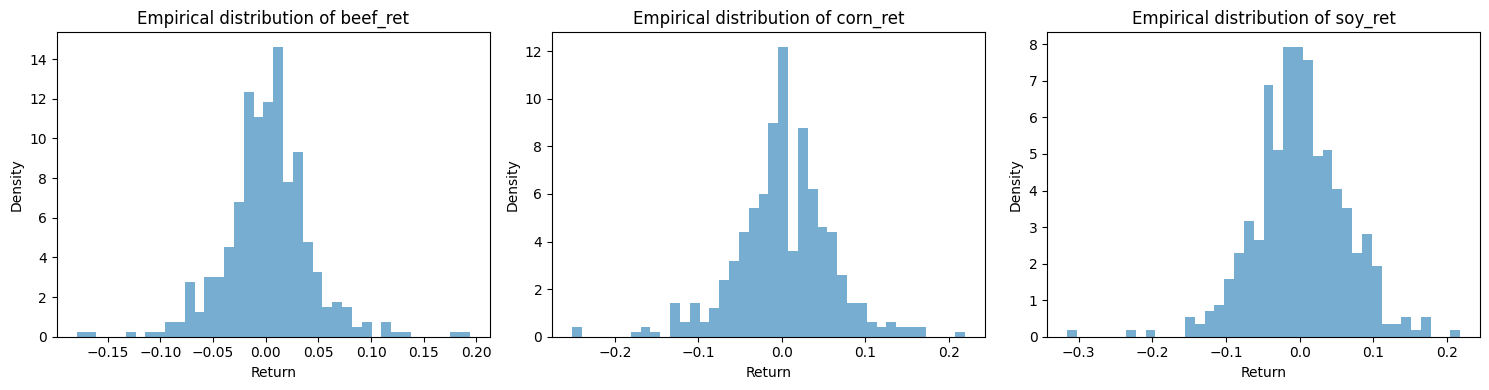

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, log_returns.columns):
    ax.hist(log_returns[col].dropna(), bins=40, density=True, alpha=0.6)
    ax.set_title(f"Empirical distribution of {col}")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


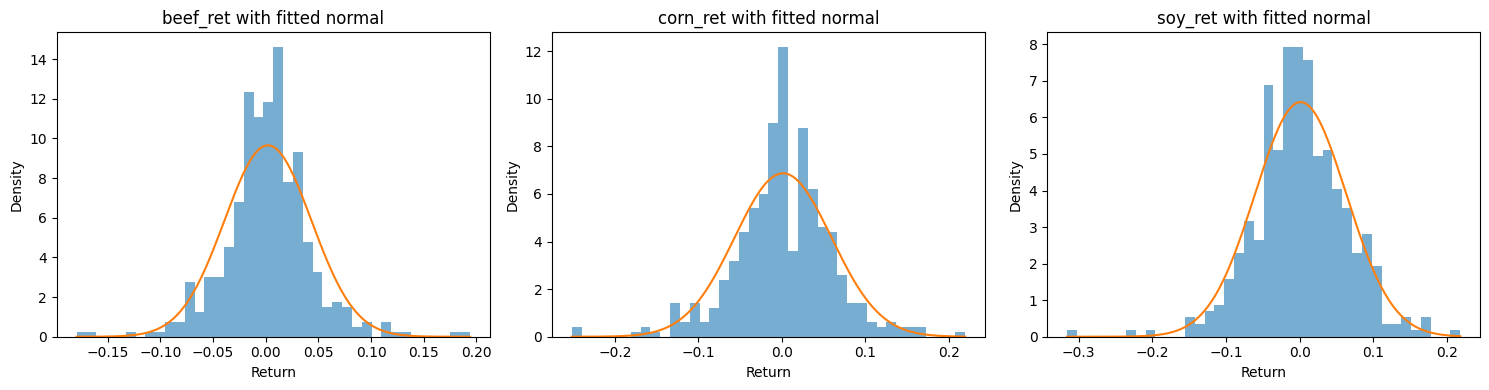

In [27]:
from scipy.stats import norm

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, log_returns.columns):
    data = log_returns[col].dropna()
    mu, sigma = data.mean(), data.std()
    
    # histogram
    ax.hist(data, bins=40, density=True, alpha=0.6)
    
    # normal pdf
    x = np.linspace(data.min(), data.max(), 200)
    ax.plot(x, norm.pdf(x, loc=mu, scale=sigma))
    
    ax.set_title(f"{col} with fitted normal")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


In [28]:
from itertools import combinations

# pseudo-observations using ranks
n = log_returns.shape[0]
U = log_returns.rank(method="average") / (n + 1.0)
U.columns = ["u_beef", "u_corn", "u_soy"]

print(U.head())


                    u_beef    u_corn     u_soy
observation_date                              
1990-02-01        0.007042  0.535211  0.173709
1990-03-01        0.607981  0.734742  0.589202
1990-04-01        0.415493  0.924883  0.732394
1990-05-01        0.502347  0.650235  0.781690
1990-06-01        0.591549  0.377934  0.239437


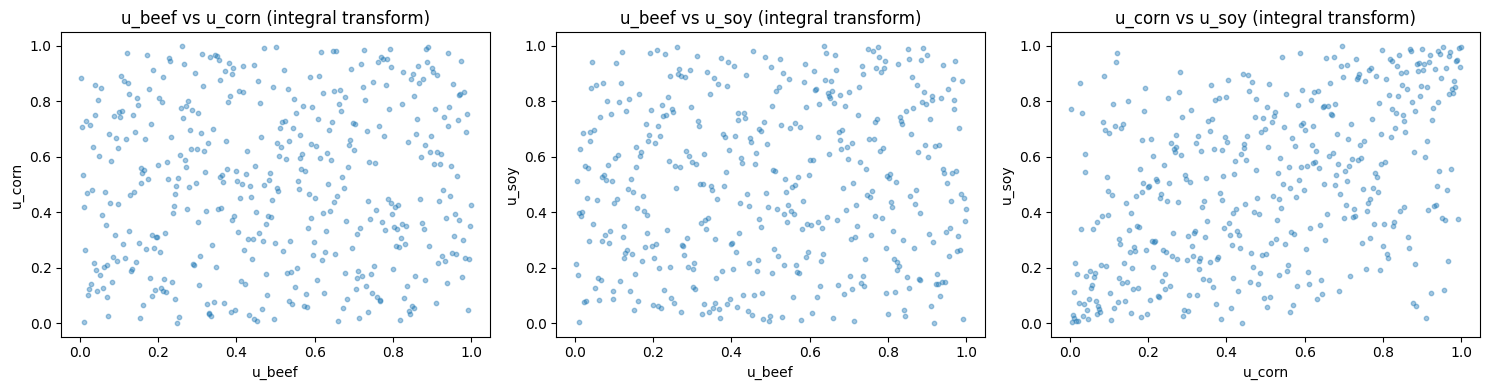

In [29]:
pairs = list(combinations(U.columns, 2))

fig, axes = plt.subplots(1, len(pairs), figsize=(5 * len(pairs), 4))

if len(pairs) == 1:
    axes = [axes]

for ax, (c1, c2) in zip(axes, pairs):
    ax.scatter(U[c1], U[c2], alpha=0.4, s=10)
    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_title(f"{c1} vs {c2} (integral transform)")

plt.tight_layout()
plt.show()


7. How to interpret & write about it (template for your report)

You’ll fill in with your actual numbers, but structure can be:

7.1 Summary statistics

Comment on:

Mean of each return series (are they near zero?).

Variances: which market is more volatile (beef vs corn vs soy)?

Correlation matrix:

Is corn_ret–soy_ret strongly positively correlated? (common drivers, feed market). 
SpringerLink
+1

Are beef returns moderately related to corn/soy returns (feed cost channel)?

7.2 Normality / distribution

Use the normality_results table:

For each variable: if Jarque–Bera p-value < 0.05 → reject normality.

Comment on histograms:

Symmetry or skewness.

Fat tails relative to normal (common in commodity returns). 
arXiv
+1

7.3 MGF

Explain: “We compute empirical MGFs 
𝑀
^
𝑋
(
𝑡
)
M
^
X
	​

(t) over t ∈ [−2,2]. For a true normal, the MGF is 
exp
⁡
(
𝜇
𝑡
+
1
2
𝜎
2
𝑡
2
)
exp(μt+
2
1
	​

σ
2
t
2
); deviations from this reflect non-normality.”

You can:

Plot log MGF vs 
𝑡
t for each series and compare shape.

Note whether MGFs grow faster/slower than a fitted normal (indicative of heavier tails).

(If you don’t need a big discussion, a short paragraph saying “MGF estimates are consistent with heavy tails and non-normality” is enough.)

7.4 Integral-transform scatter plots (copula domain)

From the U scatter plots:

If points cluster along diagonal → positive dependence.

If dependence is stronger in lower-left corner → lower tail dependence (Clayton-type). 
Copulae

If upper-right is heavier → upper tail dependence (Gumbel-type, though we didn’t estimate it here). 
Thomas Nagler

Connect that visually with which copula wins by AIC/BIC (Gaussian vs Clayton).

7.5 Copula estimation results

Use your copula_results_df:

For each pair (e.g. beef–corn):

Compare Gaussian vs Clayton:

If Clayton has lower AIC/BIC and higher log-likelihood → dependence concentrated in joint downside moves (lower-tail).

If Gaussian wins → dependence is more symmetric, no strong tail asymmetry.

Comment economically:

Example template:

“The Clayton copula provides a better fit for beef–corn returns, suggesting stronger co-movements during joint price drops. This is consistent with the idea that adverse shocks to feed markets and meat demand tend to co-occur in stress periods.”

Tie back to your original question:

“How do corn and soybean price movements relate to beef price movements?”
Copula results show shape of dependence, beyond linear correlation.